In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [6]:

class LSTMgf(MODEL):
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 train_text,
                 valid_text):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "gate_fine": 6,
                         "num_steps": 7,
                         "averaging_number": 8,
                         "type": 9}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                #list of LSTM cells in multilayered network
                cell_list = list()
                for i in range(self._num_layers):
                    cell_list.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_nodes[i], state_is_tuple=True))
                LSTM = tf.nn.rnn_cell.MultiRNNCell(cell_list, state_is_tuple=True)

                weights_initializer = tf.truncated_normal_initializer(mean=-0.1, stddev=0.1, seed=None, dtype=tf.float32)
                LSTM_scope = 'LSTM'
                with tf.variable_scope(LSTM_scope, reuse=False):
                  for i in range(self._num_layers):
                    with tf.variable_scope("Cell%d" % i):
                      with tf.variable_scope("BasicLSTMCell"):
                        with tf.variable_scope("Linear"):
                          if i == 0:
                            input_dim = self._vocabulary_size + cell_list[i].output_size
                          else:
                            input_dim = cell_list[i-1].output_size + cell_list[i].output_size
                          output_dim = 4*cell_list[i].output_size
                          tf.get_variable("Matrix", [input_dim, output_dim], initializer=weights_initializer)
                          tf.get_variable("Bias", 
                                          initializer=tf.zeros_initializer(shape=[output_dim], dtype=tf.float32))

                # classifier 
                weights = tf.Variable(tf.truncated_normal([LSTM.output_size, self._vocabulary_size], stddev = 0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """gate fine"""
                self.gf = tf.placeholder(tf.float32)
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = list()
                for i in range(self._num_layers):
                    zero_c, zero_h = cell_list[i].zero_state(self._batch_size, tf.float32)
                    shape_c = zero_c.get_shape().as_list()
                    shape_h = zero_h.get_shape().as_list()
                    saved_state.append((tf.Variable(tf.zeros(shape_c), trainable=False),
                                        tf.Variable(tf.zeros(shape_h), trainable=False)))    #AMENDMENT!!!!

                    
                Matrices = list()
                Biases = list()
                gates = list()
                with tf.variable_scope(LSTM_scope, reuse=True):
                    for i in range(self._num_layers):
                        with tf.variable_scope("Cell%d" % i):
                            with tf.variable_scope("BasicLSTMCell/Linear"):
                                Matrices.append(tf.get_variable("Matrix"))
                                Biases.append(tf.get_variable("Bias"))                    
                    
    
                outputs = list()
                state = saved_state
                for tr_i in train_inputs:
                    with tf.variable_scope('', reuse=True): 
   
                        cur_inp = tr_i
                        one_letter_gates = list()
                        for layer_num in range(self._num_layers):
                            concat = tf.matmul(tf.concat(1, [cur_inp,
                                                             state[layer_num][1]]),
                                               Matrices[layer_num]) + Biases[layer_num]
                            i, _, f, _ = tf.split(1, 4, concat)
                            one_letter_gates.append(tf.concat(0, [tf.sigmoid(i),
                                                                  tf.sigmoid(f)]))
                            with tf.variable_scope(LSTM_scope, reuse=True):
                                with tf.variable_scope("Cell%d" % layer_num):
                                    cur_inp, _ = cell_list[layer_num](cur_inp, state[layer_num])
                        
                        gates.append(tf.concat(1, one_letter_gates))
                        output, state = LSTM(tr_i, state, scope=LSTM_scope)
                    outputs.append(output)
                gates = tf.pack(gates)

                save_list = list()
                for i in range(self._num_layers):
                    save_list.append(saved_state[i][0].assign(state[i][0]))
                    save_list.append(saved_state[i][1].assign(state[i][1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits, tf.concat(0, train_labels))) + self.gf * tf.reduce_sum(gates)
                # Optimizer.
                self._global_step = tf.Variable(0)
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(10.0,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()

                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    saved_sample_state.append((tf.Variable(tf.zeros(sample_shape_c)), tf.Variable(tf.zeros(sample_shape_h))))  
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers):
                    sample_zero_c, sample_zero_h = cell_list[i].zero_state(1, tf.float32)
                    sample_shape_c = sample_zero_c.get_shape().as_list()
                    sample_shape_h = sample_zero_h.get_shape().as_list()
                    reset_list.append(saved_sample_state[i][0].assign(tf.zeros(sample_shape_c)))
                    reset_list.append(saved_sample_state[i][1].assign(tf.zeros(sample_shape_h)))
                """reste sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                with tf.variable_scope('', reuse=True): 
                    sample_output, sample_state = LSTM(self._sample_input, saved_sample_state, scope=LSTM_scope)

                sample_save_list = list()
                for i in range(self._num_layers):
                    sample_save_list.append(saved_sample_state[i][0].assign(sample_state[i][0]))
                    sample_save_list.append(saved_sample_state[i][1].assign(sample_state[i][1]))    

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                Matrices = list()
                Biases = list()
                gates = list()
                with tf.variable_scope(LSTM_scope, reuse=True):
                    for i in range(self._num_layers):
                        with tf.variable_scope("Cell%d" % i):
                            with tf.variable_scope("BasicLSTMCell/Linear"):
                                Matrices.append(tf.get_variable("Matrix"))
                                Biases.append(tf.get_variable("Bias"))
                cur_inp = self._sample_input
                for layer_num in range(self._num_layers):
                    concat = tf.matmul(tf.concat(1, [cur_inp,
                                                     saved_sample_state[layer_num][1]]),
                                       Matrices[layer_num]) + Biases[layer_num]
                    i, _, f, o = tf.split(1, 4, concat)
                    gates.append(tf.concat(0,
                                           [tf.sigmoid(i),
                                            tf.sigmoid(f),
                                            tf.sigmoid(o)]))
                    with tf.variable_scope(LSTM_scope, reuse=True):
                        with tf.variable_scope("Cell%d" % layer_num):
                            cur_inp, _ = cell_list[layer_num](cur_inp, saved_sample_state[layer_num])
                    
                """gates"""
                # important changes were made
                self.gates = tf.concat(1, gates)
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations, gf):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(gf)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append('simple_gf')
        return metadata
        
        
    def get_gates(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        gate_list = list()
        collect_gates = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_gates: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    g_list = list()
                    collect_gates = True
                text += characters(b[0], self._vocabulary)[0]
                g_list.append(self.gates.eval({self._sample_input: b[0]}))
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_gates = False
                    gate_list.append(g_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, gate_list   

In [7]:
model = LSTMgf(64,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 20,
                 1,
                 [64],
                 train_text,
                 valid_text)

In [8]:
reduce_coef = 1.58489
optional_feed_dict = {'self.gf': 0.0001}
num_iter = 20
results_GL = list()
for iteration in range(num_iter):
    print("\ngate fine: ", optional_feed_dict['self.gf'])
    model.simple_run(100,
                   'simple_gf/1/variables/1_64_%s' % optional_feed_dict['self.gf'],
                   40000,
                   4000,
                   5000,        #learning has a chance to be stopped after every block of steps
                   20,
                   0.9,
                   3,
                   optional_feed_dict=optional_feed_dict)
    results_GL.extend(model._results)
    optional_feed_dict['self.gf'] /= reduce_coef


gate fine:  0.0001
Number of steps = 40001     Percentage = 31.98%     Time = 613s     Leraning rate = 1.22

gate fine:  6.30958615424e-05
Number of steps = 40001     Percentage = 32.06%     Time = 607s     Leraning rate = 1.22

gate fine:  3.98108774378e-05
Number of steps = 40001     Percentage = 35.80%     Time = 609s     Leraning rate = 1.22

gate fine:  2.5119016107e-05
Number of steps = 40001     Percentage = 36.65%     Time = 609s     Leraning rate = 1.22

gate fine:  1.58490596237e-05
Number of steps = 40001     Percentage = 40.65%     Time = 600s     Leraning rate = 1.22

gate fine:  1.00001007159e-05
Number of steps = 40001     Percentage = 44.28%     Time = 612s     Leraning rate = 1.22

gate fine:  6.30964970184e-06
Number of steps = 40001     Percentage = 43.74%     Time = 614s     Leraning rate = 1.22

gate fine:  3.98112783969e-06
Number of steps = 40001     Percentage = 48.83%     Time = 616s     Leraning rate = 1.22

gate fine:  2.51192690956e-06
Number of steps = 400

In [9]:
folder_name = 'simple_gf'
pickle_file = 'simple_gf_20gfs.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [10]:
from plot_module import ComparePlots
plot_options = {'x': 'log'}

gf_plots = ComparePlots('simple_gf')
gf_plots.add_network(results_GL, model._indices)



{'layout_variable': None, 'fixed': None, 'data': [{'y': [51.7359375, 51.3484375, 51.365625, 51.9796875, 51.246875, 51.176562499999996, 51.753125000000004, 50.80624999999999, 51.20156250000001, 51.2078125, 51.0546875, 50.839062500000004, 48.826562500000016, 43.740625000000016, 44.28125, 40.65468750000001, 36.6453125, 35.8046875, 32.059375, 31.9765625], 'x': [1.5849538504441023e-08, 2.511977508030353e-08, 3.981208032702226e-08, 6.309776798949431e-08, 1.0000302150886964e-07, 1.584937887591924e-07, 2.511952208665564e-07, 3.981167935991966e-07, 6.309713250074306e-07, 1.0000201432910266e-06, 1.584921924900515e-06, 2.511926909555577e-06, 3.981127839685538e-06, 6.309649701839213e-06, 1.0000100715947949e-05, 1.5849059623698743e-05, 2.51190161070039e-05, 3.9810877437829405e-05, 6.309586154244144e-05, 0.0001], 'layout_value': None}], 'x_variable': ('gate_fine', None), 'several_networks': False}
There is no labels on plot


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


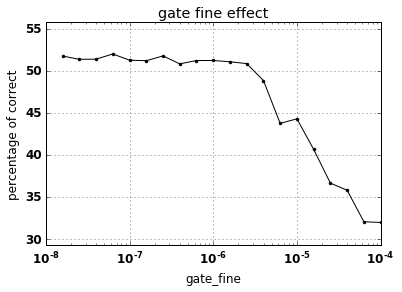

In [14]:
plot_data, _ = gf_plots.one_key_layout_data('simple_gf_1',
                                         'gate_fine',
                                         None)
print(plot_data[0])
gf_plots.save_layout(plot_data[0],
                    'gate fine effect',
                    ['1', 'plots'],
                    'nn64;ns40000;hl4000;dc0.9',
                     plot_options=plot_options)
gf_plots.draw(plot_data[0], 'gate fine effect', plot_options=plot_options)

In [12]:
folder_name = 'simple_gf'
file_name = 'simple_gf_20gfs.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling simple_gf/simple_gf_20gfs.pickle.


In [8]:
optional_feed_dict = {'self.gf': 0.00001}
text_list, gate_list = model.run_for_analitics(model.get_gates,
                                                None,
                                                [100, 75, None],
                                                [40000,
                                                 4000, # loss is calculated with frequency loss_frequency
                                                 5000, #learning has a chance to be stopped after every block of steps
                                                 20,
                                                 0.9,
                                                 3,
                                                 optional_feed_dict])

In [9]:
print('text list length: ', len(text_list))
print('gate_list_length: ', len(gate_list))
print('gates length: ', len(gate_list[0]))
print('gate_shape: ', gate_list[0][0].shape)

text list length:  99
gate_list_length:  99
gates length:  75
gate_shape:  (1, 3, 64)


In [10]:
input_list = list()
forget_list = list()
for text_number, text in enumerate(text_list):
    input_gate = list()
    forget_gate = list()
    text_gates = gate_list[text_number]
    for text_gate in text_gates:
        input_gate.append(np.mean(text_gate[0, 0, :]))
        forget_gate.append(np.mean(text_gate[0, 1, :]))
    input_list.append(input_gate)
    forget_list.append(forget_gate)
    #print('input_gate length at %s: ' % text_number, len(input_gate))
    #print('forget_gate length at %s: ' % text_number, len(forget_gate))
#print('input_list: ', input_list)
#print('forget_list: ', forget_list)
print('input_list length: ', len(input_list))
print('forget_list length: ', len(forget_list))


input_list length:  99
forget_list length:  99


[u'\n', u'&', u']', u'=', u';', u'}', u'{', u' ', u'.', u'[', u'/', u'|', u')', u'0', u"'", u'-', u'_', u'1', u'4', u'8', u'9', u'6', u'7', u'5', u'\xf3', u'3', u':', u'2', u'(', u',', u'\xe9']


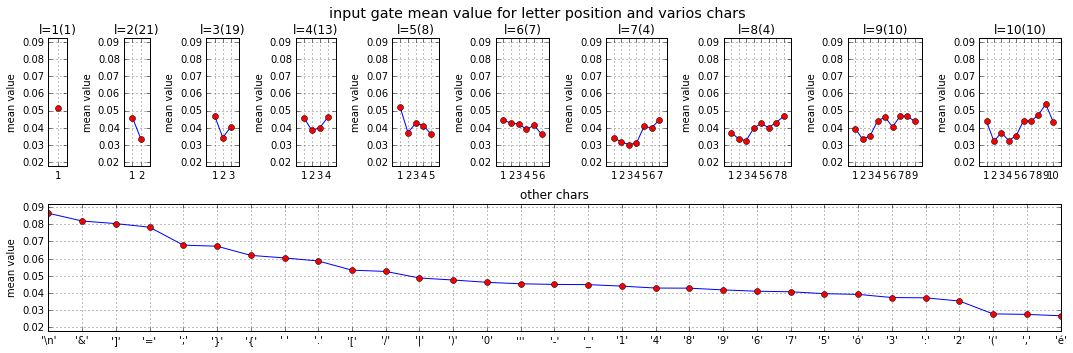

In [11]:
structure_vocabulary_plots(text_list,
                           input_list,
                           'input gate mean value for letter position and varios chars',
                           'mean value',
                           ['simple_gf', '1', 'gates'],
                           'mean_input',
                           show=True)  

[u'4', u'(', u'8', u"'", u'/', u'5', u'9', u'0', u'7', u'6', u'3', u'2', u'[', u'{', u'=', u'1', u':', u',', u'\xf3', u'|', u'\xe9', u'_', u'&', u'-', u'.', u')', u'}', u']', u'\n', u' ', u';']


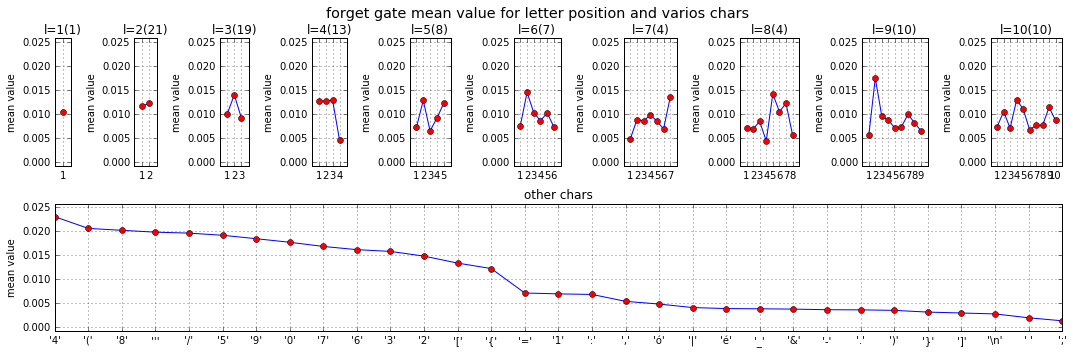

In [12]:

structure_vocabulary_plots(text_list,
                           forget_list,
                           'forget gate mean value for letter position and varios chars',
                           'mean value',
                           ['simple_gf', '1', 'gates'],
                           'mean_forget',
                           show=True)